# Neural networks for images

* Introduction
    * Visualisations of dataset
* Supervised: Two-layer perceptron
* Supervised: Convolutional neural network
* Supervised: Recurrent neural network
* Unsupervised: Generative adverserial network
    * Conditional Generative adversarial network

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## 1.1 MNIST dataset

The MNIST dataset consists of 70000 images of handwritten digits, 60000 used for training and 10000 for testing. The dataset is simple and very useful for benchmarking and experimenting with various classifiers. Due to the relatively small size of this dataset, the training times of classifiers with larger numbers of parameters on this dataset with limited hardware are reasonable, making this dataset a suitable choice for this notebook.

In [2]:
# With the MNIST dataset downloaded and stored in the folder 'data',
# the files are loaded and saved to disk as 'pkl' files for fast access
from mnist import load_and_pickle, load_from_pickle

mnist_dir = './data/'

if 'mnist.pkl' not in os.listdir(mnist_dir):
    load_and_pickle(mnist_dir)
data = load_from_pickle(mnist_dir + 'mnist.pkl')

Xtrain, ytrain = data['Xtrain'] / 255, data['ytrain']
Xtest, ytest = data['Xtest'] / 255, data['ytest']

In [3]:
# Viewing the sizes of the training and test sets
print('Size of training images:', Xtrain.shape)
print('Size of training labels:', ytrain.shape)
print('Size of training images:', Xtest.shape)
print('Size of training labels:', ytest.shape)

Size of training images: (60000, 28, 28)
Size of training labels: (60000,)
Size of training images: (10000, 28, 28)
Size of training labels: (10000,)


### Visualisations of dataset

Dimensionality reduction techniques offer ways for datasets to be visualised. Principal component analysis (PCA) is a common and standard algorithm to perform dimensionality reduction. PCA is useful because the data is projected on axes along which the variances of the data are greatest. In this sense, PCA offers also a way to perform feature selection where (i) features which are largely constant across the training set can be determined and ignored, and (ii) any correlations between features are eliminated when performing dimensionality reduction with PCA.

For visualising the MNIST dataset, the PCA algorithm was implemented (in numpy) and the dimension of the training set reduced by projecting the data onto the axes capturing the greatest variabilities of the data. The projection of the training set onto the first two and three principal components was performed and the visualisations of the dataset shown.

Shape of training set with reduced dimensions:  (60000, 2)
Shape of training set with reduced dimensions:  (60000, 3)


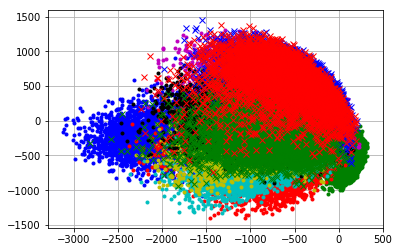

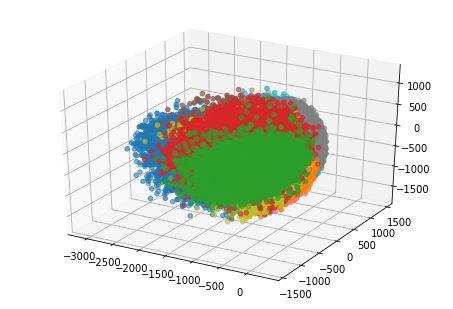

In [4]:
# Reshaping the training and test images
N, H, W = Xtrain.shape
Xtrain = Xtrain.reshape(N, H*W)
N, H, W = Xtest.shape
Xtest = Xtest.reshape(N, H*W)

from pca import PCA

pca = PCA()

pca.train(Xtrain)
Xtrain_2d = pca.test(Xtrain, 2)
Xtrain_3d = pca.test(Xtrain, 3)
print('Shape of training set with reduced dimensions: ', Xtrain_2d.shape)
print('Shape of training set with reduced dimensions: ', Xtrain_3d.shape)

pt_ = ['b.', 'g.', 'r.', 'c.', 'm.', 'y.', 'k.', 'bx', 'gx', 'rx']
# 2-D visualisation of training set
plt.figure()
ax = plt.axes()
for c in range(10):
    idx = np.nonzero(ytrain == c)
    ax.plot(Xtrain_2d[idx, 0], Xtrain_2d[idx, 1], pt_[c])
plt.grid(True)
plt.show()

# 3-D visualisation of training set
fig = plt.figure()
ax = Axes3D(fig)
for c in range(10):
    idx = np.nonzero(ytrain == c)
    ax.scatter(Xtrain_3d[idx, 0], Xtrain_3d[idx, 1], Xtrain_3d[idx, 2], pt_[c])
plt.grid(True)
plt.show()

Visualisations of dataset can sometimes help determine if the dataset is sufficiently discriminative for classification. The above visualisations show that data points belonging to a particular class are largely clustered together. Although overlaps between data points of different classes are observed, the discrimination between different classes is not expected to be lost when higher dimensions are considered.

Visualisations with PCA show only the data points along the axes of greatest variabilities. More useful visualisations can be made with tSNE, a non-linear dimensionality reduction technique commonly used in deep learning. Unlike PCA, tSNE preserves the relative distances between neighbouring data points when projecting to lower dimensions. A visualisation of the reduced training set using tSNE is shown below. Clear clusters formed by data points belonging to a particular class were observed, although some outliers were also seen far from the cluster centroids. This thus suggest that the given dataset is sufficiently discriminative.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.078s...
[t-SNE] Computed neighbors for 1000 samples in 8.129s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.729028
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.692184
[t-SNE] Error after 1000 iterations: 1.064781


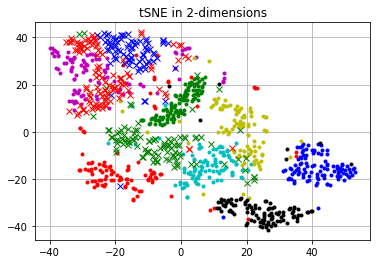

In [4]:
# Reshaping the training and test images
N, H, W = Xtrain.shape
Xtrain = Xtrain.reshape(N, H*W)
N, H, W = Xtest.shape
Xtest = Xtest.reshape(N, H*W)

from sklearn.manifold import TSNE

# Randomly select 1000 training data points
rand_idx = np.random.choice(60000, size=1000)
Xtrain_ = Xtrain[rand_idx, :]
ytrain_ = ytrain[rand_idx]

tsne = TSNE(n_components=2, init='pca', verbose=1)
Xtrain_2d = tsne.fit_transform(Xtrain_)

pt_ = ['b.', 'g.', 'r.', 'c.', 'm.', 'y.', 'k.', 'bx', 'gx', 'rx']
# 2-D visualisation of reduced training set
plt.figure()
ax = plt.axes()
for c in range(10):
    idx = np.nonzero(ytrain_ == c)
    ax.plot(Xtrain_2d[idx, 0], Xtrain_2d[idx, 1], pt_[c])
plt.title('tSNE in 2-dimensions')
plt.grid(True)
plt.show()

# 2 Two-layer perceptron

It is useful to check the classification of the dataset with a multi-layer perceptron before attempting to achieve state-of-the-art classification accuracies with more sophisticated classifiers. A two-layer perceptron with $n$ hidden layer neurons was implemented (in numpy) to classify the MNIST dataset. The training of the neural network and the classification accuracies of the trained network on the training and test sets are shown below.

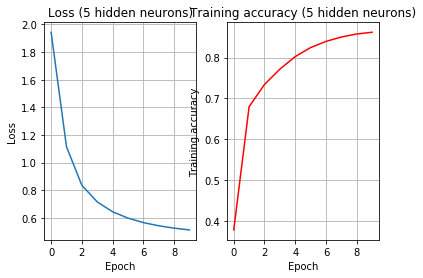

Accuracy on test set (5 hidden neurons): 0.8642


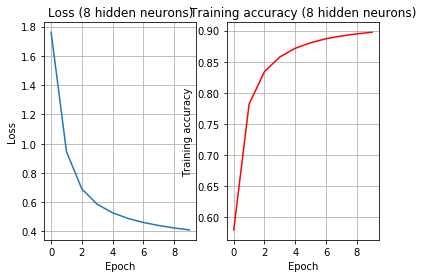

Accuracy on test set (8 hidden neurons): 0.8988


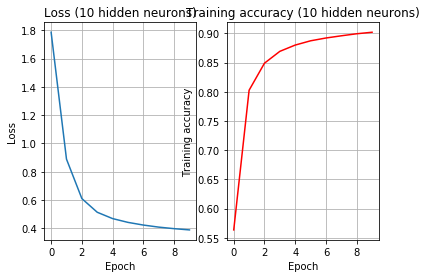

Accuracy on test set (10 hidden neurons): 0.9051


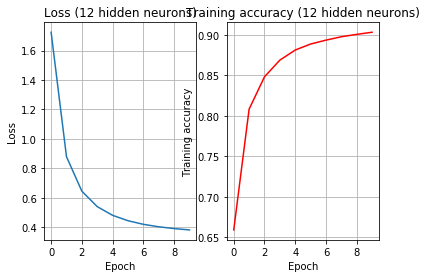

Accuracy on test set (12 hidden neurons): 0.904


In [3]:
from classifiers import TwoLayerNet

Xtrain = Xtrain.reshape(60000, 28*28)
Xtest = Xtest.reshape(10000, 28*28)

for n_hidden in [5, 8, 10, 12]:
    nn = TwoLayerNet(input_dim=Xtrain.shape[1], n_classes=10, n_hidden=n_hidden)
    train_stats = nn.fit(X=Xtrain, y=ytrain, learn_rate=0.01)

    # Plotting training history
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(train_stats['ite'], train_stats['loss'])
    ax1.set_title('Loss ({} hidden neurons)'.format(n_hidden))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax2.plot(train_stats['ite'], train_stats['train_acc'], 'r')
    ax2.set_title('Training accuracy ({} hidden neurons)'.format(n_hidden))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Training accuracy')
    ax2.grid(True)
    plt.show()

    # Performance on test set
    y_pred = nn.predict(Xtest)
    test_acc = np.count_nonzero(y_pred==ytest) / Xtest.shape[0]
    print('Accuracy on test set ({} hidden neurons): {}'.format(n_hidden, test_acc))

As demonstrated, the trained networks were able to accurately classify $90\%$ of the test set. The test accuracy is also generally higher with increased number of hidden layer neurons since networks with larger number of hidden layer neurons are able to map more complex decision boundaries and overfit to the test set.

**Visualisation of learned weights**

It is useful to visualise the learned weights of the first layer. The weights associated with each hidden layer neuron are visualised as images with same dimensions as the input images. Each visualisation can be interpreted as the attributes of any given input image that each hidden layer neuron is finding.

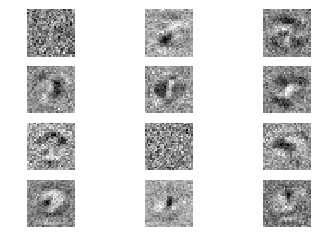

In [4]:
# First layer weight has shape (28*28, n_hidden=12)
for i in range(n_hidden):
    w1 = nn.W1[:, i].reshape(28, 28)
    w1 += np.min(w1)
    w1 /= np.max(w1)
    
    plt.subplot(4, 3, i+1)
    plt.imshow(w1, cmap='gray_r')
    plt.axis('off')
plt.show()

# 3 Convolutional neural network

As shown above, a two-layer perceptron can give reasonable classification performances on the given dataset. However, the use of MLPs alone are not preferred in more general image classification problems. There are at least three rationales for the use of convolutional neural networks (CNNs) over MLPs or other conventional machine learning classifiers that can be immediately listed:
1. MLPs and other conventional machine learning classifiers fail quickly when input images contain more than one channel
2. Spatial structure of input images, which may be important for improved performances, are not preserved by MLPs
3. Performances of conventional machine learning classifiers, including MLPs, do not scale with increased training data

It is shown below the training of an implemented CNN with architecture similar to the LeNet-5 neural network on the MNIST dataset. After 10 training epochs, the CNN was able to accurately classify up to $99\%$ of the test set. Clearly, for the given dataset, CNNs are able to generalise to new data better than multi-layer perceptrons.

In [3]:
import torch

Xtrain = (torch.from_numpy(Xtrain).float()).reshape(60000, 1, 28, 28)
ytrain = torch.from_numpy(ytrain).long()
Xtest = (torch.from_numpy(Xtest).float()).reshape(10000, 1, 28, 28)
ytest = torch.from_numpy(ytest).long()

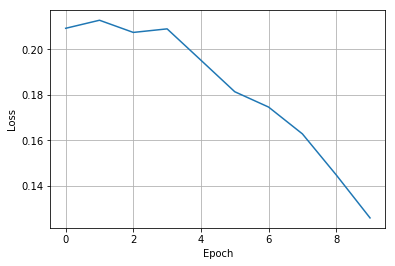

Accuracy on test set: 0.9879


In [5]:
from classifiers import CNN

cnn = CNN()
train_history = cnn.fit(Xtrain, ytrain)
#torch.save(cnn, './trained_models/trained_cnn.pth')

plt.figure()
plt.plot(train_history['ite'], train_history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

for p in cnn.parameters():
    p.requires_grad = False

# Evaluating trained CNN on test set    
scores = cnn(Xtest)
y_pred = torch.argmax(scores, dim=1)
test_acc = torch.sum(y_pred == ytest).item() / Xtest.shape[0]
print('Accuracy on test set: {}'.format(test_acc))

**Visualisation of learned weights**

Filters of the first convolutional layer operating on input images have the same number of channels as the input images. Learned weights of this convolutional layer can thus be easily visualised with images with dimensions the kernel size of the convolutional filters. Visualisations of the learned weights of the first convolutional layer (kernel size 5$\times$5) are shown.

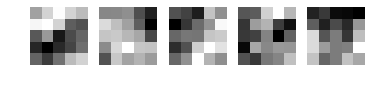

In [16]:
# Visualising trained parameters
cnn = torch.load('./trained_models/trained_cnn.pth')
for i, p in enumerate(cnn.parameters()):
    p.requires_grad = False
    if i==0:
        filters = p

# First layer filters has shape (5, 1, 5, 5)
filters = np.array(filters)

for i in range(5):
    filter = filters[i, 0, :, :]
    filter += np.min(filter)
    filter /= np.max(filter)
    
    plt.subplot(1, 5, i+1)
    plt.imshow(filter, cmap='gray_r')
    plt.axis('off')
plt.show()

# 4 Recurrent neural network

Recurrent neural networks (RNNs) are used on sequential data containing time-steps. To use RNNs on the MNIST dataset, a given image of dimensions $28\times28$ can be viewed as a 28-dimensional data vector containing 28 time-steps.

It is shown below the training of a RNN on the MNIST dataset. The RNN was made to have the LSTM architecture to enable learning of long-term dependencies. After 3 training epochs, the RNN was able to accurately classify up to $98\%$ of the test set, comparable to the performance of the CNN above.

In [3]:
import torch

Xtrain = (torch.from_numpy(Xtrain).float()).reshape(60000, 28, 28)
ytrain = torch.from_numpy(ytrain).long()
Xtest = (torch.from_numpy(Xtest).float()).reshape(10000, 28, 28)
ytest = torch.from_numpy(ytest).long()

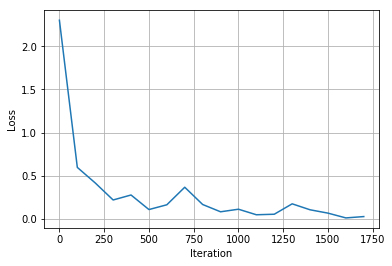

Accuracy on test set: 0.9686


In [4]:
from classifiers import LSTM

rnn = LSTM()
train_history = rnn.fit(Xtrain, ytrain)
#torch.save(rnn, './trained_models/trained_rnn.pth')

# Plotting loss against iterations
# Note: 600 iterations = 1 epoch
plt.figure()
plt.plot(train_history['ite'], train_history['loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

for p in rnn.parameters():
    p.requires_grad = False
    
# Evaluating trained RNN on test set
scores = rnn(Xtest)
y_pred = torch.argmax(scores, dim=1)
test_acc = torch.sum(y_pred == ytest).item() / Xtest.shape[0]
print('Accuracy on test set: {}'.format(test_acc))

# 5 Generative adversarial networks

Neural networks can be made to generate outputs that are similar to the training set by jointly training two neural networks in a minimax fashion. GANs consist of a generator network generating images from random noise, and a discriminator network discriminating between real images from the training set and fake images generated by the generator network. The training of the networks involves updating parameters of the generator network such that generated images are not distinguished by the discriminator network. Similarly, the parameters of the discriminator network are updated such that real and fake images can be distinguished.

A GAN was implemented to sample from the MNIST dataset. For reasonable training times, the generator and discriminator networks were made to consist only of fully-connected layers. Images generated by the generator network from noise inputs are shown for after every training epoch. The generator network trained for 5 epochs was able to generate images that reasonably resemble images from the training set.

In [3]:
import torch
import matplotlib.gridspec as gridspec

Xtrain = (torch.from_numpy(Xtrain).float()).reshape(60000, 1, 28, 28)

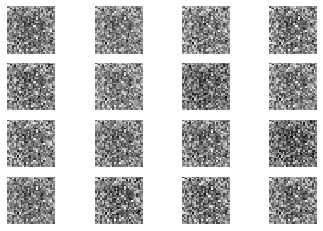

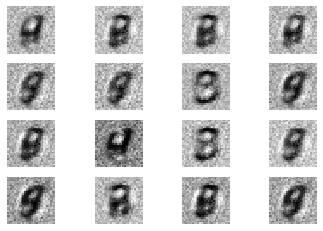

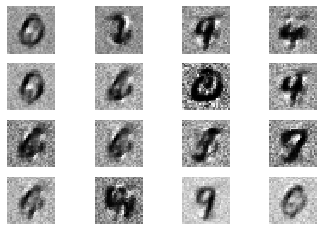

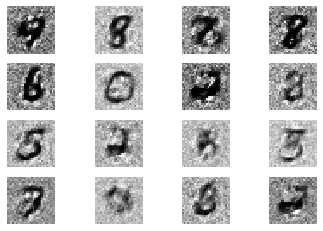

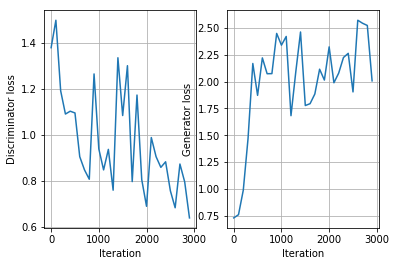

In [4]:
from gan import GAN, discriminator, generator

gan = GAN()

train_history = gan.fit(Xtrain)

#torch.save(gan.generator, './trained_models/gan_generator.pth')
#torch.save(gan.discriminator, './trained_models/gan_discriminator.pth')

# Plotting training history        
plt.subplot(1,2,1)
plt.plot(train_history['ite'], train_history['dis_loss'])
plt.xlabel('Iteration')
plt.ylabel('Discriminator loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_history['ite'], train_history['gen_loss'])
plt.xlabel('Iteration')
plt.ylabel('Generator loss')
plt.grid(True)
plt.show()

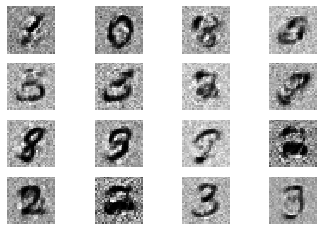

In [4]:
# Display images generated from trained generator network
from gan import GAN, discriminator, generator

gan = GAN()
gan.generator = torch.load('./trained_models/gan_generator.pth')

img = gan.predict()
gan.display_images(img)

## 5.1 Conditional Generative adversarial network

For the GAN implemented above, only random noise is presented to the generator at test time, and no control can be made over the variety of images generated. A simple extension to GANs, via the provision of conditioning information to the generator and discriminator networks, allows for learning to generate images based on the given conditioning information. 

In this case, to make the network generate only images from a certain class, the conditioning information in the form of class labels of training images were provided to the generator and discriminator during training. Training in the same way as the implemented GAN above after 5 epochs, the network was able to generate images belonging to each of the 10 classes.

In [3]:
import torch
import matplotlib.gridspec as gridspec

from c_gan import C_GAN, discriminator, generator

Xtrain = (torch.from_numpy(Xtrain).float()).reshape(60000, 1, 28, 28)
# One-hot encoding
ytrain_ = torch.zeros(60000, 10)
ytrain_[range(60000), ytrain] = 1

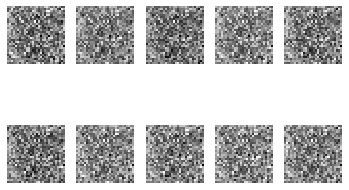

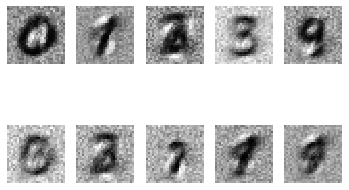

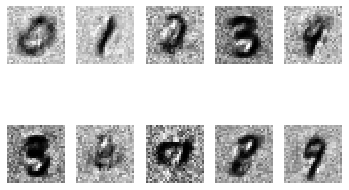

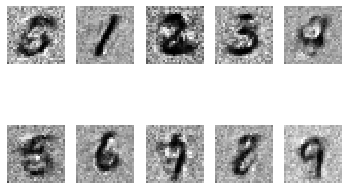

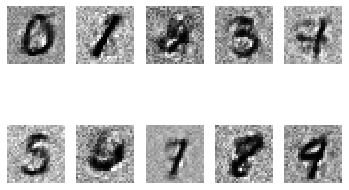

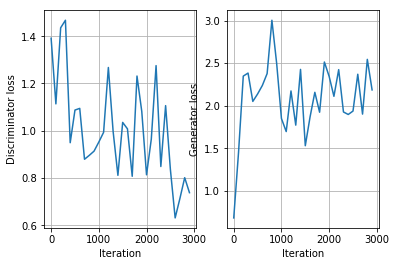

In [4]:
c_gan = C_GAN()

train_history = c_gan.fit(Xtrain, ytrain_)

#torch.save(c_gan.generator, './trained_models/c_gan_generator.pth')
#torch.save(c_gan.discriminator, './trained_models/c_gan_discriminator.pth')

# Plotting training history        
plt.subplot(1,2,1)
plt.plot(train_history['ite'], train_history['dis_loss'])
plt.xlabel('Iteration')
plt.ylabel('Discriminator loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_history['ite'], train_history['gen_loss'])
plt.xlabel('Iteration')
plt.ylabel('Generator loss')
plt.grid(True)
plt.show()

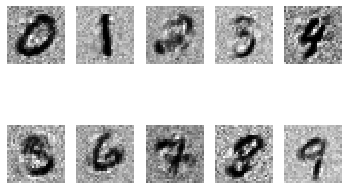

In [7]:
# Display images generated from trained generator network
from c_gan import C_GAN, discriminator, generator

c_gan = C_GAN()
c_gan.generator = torch.load('./trained_models/c_gan_generator.pth')
c_gan.discriminator = torch.load('./trained_models/c_gan_discriminator.pth')

N = 10
labels = torch.zeros((N, N))
labels[range(N), range(N)] = 1

img = c_gan.predict(N, labels)
c_gan.display_images(img)